In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
# with tf.Session() as sess:
#     print (sess)
#     if 'session' in locals() and sess is not None:
#         print('Close interactive session')
#         sess.close()
#     print (sess)

In [3]:
env = gym.envs.make("MountainCarContinuous-v0")
print (env.action_space)
print ('Sample:',env.observation_space.sample())
print ('Low:',env.observation_space.low)
print ('High:',env.observation_space.high)

[2017-02-18 16:35:07,073] Making new env: MountainCarContinuous-v0


Box(1,)
Sample: [-0.21213569  0.03012651]
Low: [-1.2  -0.07]
High: [ 0.6   0.07]


In [4]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
print ('Env.Observation_Space:',env.observation_space)
print ('Env Sample:',env.observation_space.sample())
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

Env.Observation_Space: Box(2,)
Env Sample: [-0.11502592  0.00628365]


FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [5]:
def featurize_state(state):
    """
    Returns the featurized representation for a state.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

a = featurize_state([-0.11502592, 0.00628365])
print (len(a))

400


5 5.00671534849


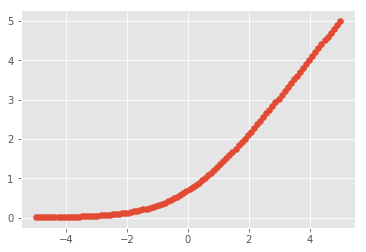

In [6]:
import matplotlib.pyplot as plt
softplus = lambda x: np.log(1+np.exp(x))
# for each in zip([x for x in np.linspace(0,1,100)],[softplus(x) for x in np.linspace(0,1,100)]):
#     print (each)
y_min = -5; y_max = 5
print (y_max, softplus(y_max))
plt.scatter([x for x in np.linspace(y_min,y_max,100)],[softplus(x) for x in np.linspace(y_min,y_max,100)])
plt.show()

In [7]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    Input is the env.state
    ->we have two neural nets here: mu and sigma
    ->combine them both to get a normal distro (mean, standard deviation)
    ->pick an action from that normal distro
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.action = tf.placeholder(dtype=tf.float32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.mu = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),   #a vector with 10 elements could be treat as a 10x1 matrix
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            self.mu = tf.squeeze(self.mu)
            
            self.sigma = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
            self.sigma = tf.squeeze(self.sigma)
            self.sigma = tf.nn.softplus(self.sigma) + 1e-5
            self.normal_dist = tf.contrib.distributions.Normal(self.mu, self.sigma)
            self.action = self.normal_dist.sample_n(1)
            self.action = tf.clip_by_value(self.action, env.action_space.low[0], env.action_space.high[0]) #a scalar value

            # Loss and train op
            self.loss = -self.normal_dist.log_prob(self.action) * self.target
            #according to docs, the log_prob function is the (log(probability density/mass function))
            #loss = log(pmf(self.action))*td_error*-1 (if td_error is positive, we love the action, hence loss is negative)
            
            # Add cross entropy cost to encourage exploration
            self.loss -= 1e-1 * self.normal_dist.entropy()
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.action, { self.state: state })

    #env.state, td_error, env.action
    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [8]:
class ValueEstimator():
    """
    Value Function approximator. 
    Here the neural net tries to map an  (env.curr_state) to a (value_function.value OR td_target)
        where, td_target(curr_state) = reward + ValueEstimator.predict(next_state)
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [9]:
#Read this to understand: https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node66.html

import time
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        print ('====================================================================Episode:',i_episode+1, ' started')
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        t1 = time.time()
        for t in itertools.count():
            
            # env.render()
            
            # Take a step
            action = estimator_policy.predict(state)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target (#Ideal situation --> value_current = reward + value_next*gamma)
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state) #if positive, we love the action???(why)
            #1. if positive, it means that the predicted value is less than the actual value. 
            #1.1 That means the action led to an increase in value of the state-value function
            
            # Update the value estimator
            estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.
            if t%1000 == 0:
                print("\rStep {} @ Episode {}/{} ({})".format(
                        t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
                print ('\nStep:',t,'\tState:',state,'\tAction:',action,'\tReward:',reward)
                print ('TD Error:',td_error, '\t(',round(time.time() - t1),'s)')

            if done:
                break
                
            state = next_state
    print ('-------------------------------------------------------------------------->DONE!')
    for i_episode in range(num_episodes):
        print ('i:',i_episode, '\tReward:',stats.episode_rewards[i_episode], '\tLength:',stats.episode_lengths[i_episode])
    return stats

In [10]:
tf.reset_default_graph()  #resets the default graph to empty (https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/api_docs/python/functions_and_classes/shard8/tf.reset_default_graph.md)

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(learning_rate=0.001)
value_estimator = ValueEstimator(learning_rate=0.1)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    print ('Session Oject:',sess)
    sess.run(tf.global_variables_initializer())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # TODO: Sometimes the algorithm gets stuck, I'm not sure what exactly is happening there.
    num_episodes = 1 #50
    stats = actor_critic(env, policy_estimator, value_estimator, num_episodes, discount_factor=0.95)
    sess.close()

print ('\n-------------- PRINTING STATS ------------------' )

Session Oject: <tensorflow.python.client.session.Session object at 0x00000199BF578748>
====================================================================Episode: 1  started


InternalError: Blas SGEMM launch failed : a.shape=(1, 400), b.shape=(400, 1), m=1, n=1, k=400
	 [[Node: policy_estimator/fully_connected/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](policy_estimator/ExpandDims, policy_estimator/fully_connected/weights/read)]]
	 [[Node: policy_estimator/clip_by_value/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_31_policy_estimator/clip_by_value", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'policy_estimator/fully_connected/MatMul', defined at:
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-41f7b3c43aa4>", line 4, in <module>
    policy_estimator = PolicyEstimator(learning_rate=0.001)
  File "<ipython-input-7-698cf8f5531f>", line 21, in __init__
    weights_initializer=tf.zeros_initializer)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\tensorflow\contrib\framework\python\ops\arg_scope.py", line 177, in func_with_args
    return func(*args, **current_args)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py", line 1350, in fully_connected
    outputs = standard_ops.matmul(inputs, weights)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1729, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 1442, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\tensorflow\python\framework\ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "c:\users\prerak - nonwork\.conda\envs\py3.5\lib\site-packages\tensorflow\python\framework\ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Blas SGEMM launch failed : a.shape=(1, 400), b.shape=(400, 1), m=1, n=1, k=400
	 [[Node: policy_estimator/fully_connected/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](policy_estimator/ExpandDims, policy_estimator/fully_connected/weights/read)]]
	 [[Node: policy_estimator/clip_by_value/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_31_policy_estimator/clip_by_value", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
plotting.plot_episode_stats(stats, smoothing_window=10)